## DCv2 analysis

Scope:

- Analyze evolution of sum of squared angular distances (SSD) between samples and cluster centers w.r.t training epoch
- Perform analysis for different number of clusters used (e.g. $k = 2, 4, 6, 8, ..., 40$)

Results:

- SSD is lowest for $k = 30$
- SSD increases each epoch, and should eventually saturate and drop again, which is not observed for 800 epochs.


In [2]:
import torch
import pathlib
import numpy as np
import logging
import matplotlib.pyplot as plt

import a6
import a6.plotting._colors as _colors


a6.utils.logging.create_logger(
    global_rank=0,
    local_rank=0,
    verbose=False,
)
logger = logging.getLogger("notebook")

device = torch.device("cpu")

plots = pathlib.Path("/p/project1/deepacf/emmerich1/plots/paper-1")

scratch = pathlib.Path("/p/project1/deepacf/emmerich1/dcv2")
path_k40_2_crops = scratch / "multi-level-all-fields-1964-2023"


def get_k_from_file_name(p: pathlib.Path) -> int:
    return int(p.name.split("-")[-1])


def sort_by_k(paths: list[pathlib.Path]) -> list[pathlib.Path]:
    return sorted(paths, key=lambda p: get_k_from_file_name(p))


results = sort_by_k(
    scratch.glob("multi-level-all-fields-1964-2023-1200-epochs-k-*")
)
ks = [get_k_from_file_name(p) for p in results]
ks

[2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 34, 38, 40]

## Plot random crop examples

In [338]:
import torchvision

# dataset = torchvision.datasets.CIFAR10(
#     root="/p/project1/deepacf/emmerich1/data/cifar10",
#     train=True,
#     download=True,
# )
dataset = torchvision.datasets.MNIST(
    root="/p/project1/deepacf/emmerich1/data/mnist",
    train=True,
    download=True,
)

In [99]:
import torchvision


def create_transform(
    nmb_crops: list[int],
    size_crops: list[float | tuple[float, float]],
    min_scale_crops: list[float],
    max_scale_crops: list[float],
    mean: list[float] | None = None,
    std: list[float] | None = None,
    to_tensor: bool = True,
):
    return [
        # Define transform pipeline
        torchvision.transforms.Compose(
            list(
                filter(
                    None,
                    [
                        # torchvision.transforms.PILToTensor(),
                        torchvision.transforms.RandomResizedCrop(
                            size,
                            scale=(min_scale, max_scale),
                            antialias=True,
                        ),
                        ###
                        # (
                        #     torchvision.transforms.ToTensor()
                        #     if to_tensor
                        #     else None
                        # ),
                        # torchvision.transforms.Normalize(mean=mean, std=std),
                    ],
                )
            )
        )
        for n_crops, size, min_scale, max_scale in zip(
            nmb_crops, size_crops, min_scale_crops, max_scale_crops, strict=True
        )
        # Repeat transform for `n_crops` to achieve the given number of crops
        for _ in range(n_crops)
    ]

RANK 0 (LOCAL 0) - WARNING - 2024-07-11 14:07:43 - 0:00:39 - Converted relative crop sizes ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)) to absolute crop sizes [(28, 28), (28, 28), (11, 11)]


torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([11, 11, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([11, 11, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([11, 11, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([11, 11, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([11, 11, 1])


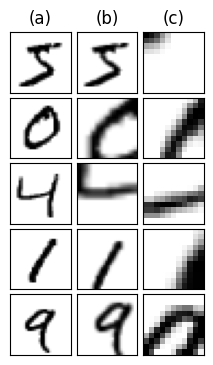

In [340]:
sample = np.array(dataset[0][0])
absolute_sizes = a6.datasets.crop.convert_relative_to_absolute_crop_size(
    ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)),
    size_x=sample.shape[0],
    size_y=sample.shape[1],
)
transforms = create_transform(
    nmb_crops=(1, 1, 1),
    size_crops=absolute_sizes,
    min_scale_crops=(1.0, 0.14, 0.05),
    max_scale_crops=(1.0, 1.0, 0.14),
)
n_images = 5
n_crops = 3
fig, axs = plt.subplots(
    figsize=(0.75 * n_crops, 0.75 * n_images), nrows=n_images, ncols=n_crops
)

for i in range(n_images):
    image, label = dataset[i]
    crops = list(map(lambda trans: trans(image), transforms))
    row = axs[i]

    for j, crop in enumerate(crops):
        ax = row[j]
        if i == 0:
            if j == 0:
                label = "a"
            elif j == 1:
                label = "b"
            elif j == 2:
                label = "c"

            ax.set_title(f"({label})")

        # ax.set_title(f"{label}")
        print(crop.permute(1, 2, 0).shape)

        ax.imshow(torchvision.transforms.ToPILImage()(crop), cmap="gray_r")

        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])


fig.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.savefig(plots / "mnist-crop-examples.pdf")

In [100]:
import xarray as xr
import itertools

ds = xr.open_dataset(
    "/p/project1/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12.nc"
)
print(ds.level)

level = 950

coordinates = a6.datasets.coordinates.Coordinates()
variables = a6.datasets.variables.Model()

ds_sub = (
    a6.features.methods.geopotential.calculate_geopotential_height(
        variables=variables,
    )
    >> a6.features.methods.wind.calculate_wind_speed(
        variables=variables,
    )
    >> a6.datasets.methods.select.select_variables(
        variables=[
            variables.geopotential_height,
            variables.t,
            variables.r,
            variables.u,
            variables.v,
        ]
    )
).apply_to(ds.isel(time=slice(0, 1)))


absolute_sizes = a6.datasets.crop.convert_relative_to_absolute_crop_size(
    ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)),
    size_x=ds[coordinates.latitude].size,
    size_y=ds[coordinates.longitude].size,
)

transforms = create_transform(
    nmb_crops=(1, 1, 1),
    size_crops=absolute_sizes,
    min_scale_crops=(1.0, 0.14, 0.05),
    max_scale_crops=(1.0, 1.0, 0.14),
)
image = a6.datasets.transforms.xarray.concatenate_levels_to_channels(
    ds_sub,
    time_index=0,
    levels=[level],
    coordinates=coordinates,
)
multi_crops = list(map(lambda trans: trans(image), transforms))
print(len(multi_crops), [t.shape for t in multi_crops])


n_crops = len(multi_crops)
n_variables = multi_crops[0].shape[0]

field_names = [
    f"$z_{{{level}}}$ [m]",
    f"$t_{{{level}}}$ [K]",
    f"$r_{{{level}}}$ [%]",
    f"$u_{{{level}}}$ [m/s]",
    f"$v_{{{level}}}$ [m/s]",
]
panels = [multi_crops[j][i] for i in range(n_variables) for j in range(n_crops)]
maxs = [max(crop[i].max() for crop in multi_crops) for i in range(n_variables)]
mins = [min(crop[i].min() for crop in multi_crops) for i in range(n_variables)]
maxs, mins, panels, len(panels)

RANK 0 (LOCAL 0) - WARNING - 2024-07-19 17:22:21 - 3:49:12 - Converted relative crop sizes ((1.0, 1.0), (1.0, 1.0), (0.4, 0.4)) to absolute crop sizes [(141, 221), (141, 221), (56, 88)]


<xarray.DataArray 'level' (level: 5)>
array([300, 500, 700, 850, 950], dtype=int32)
Coordinates:
  * level    (level) int32 300 500 700 850 950
Attributes:
    units:      millibars
    long_name:  pressure_level
3 [torch.Size([5, 141, 221]), torch.Size([5, 141, 221]), torch.Size([5, 56, 88])]


([tensor(64.8442),
  tensor(286.0161),
  tensor(105.7124),
  tensor(15.8731),
  tensor(31.9261)],
 [tensor(17.2643),
  tensor(258.6772),
  tensor(22.7606),
  tensor(-36.4647),
  tensor(-19.7015)],
 [tensor([[45.9614, 45.9732, 45.9861,  ..., 51.1974, 51.2397, 51.2869],
          [45.7027, 45.7145, 45.7274,  ..., 51.2469, 51.2633, 51.2869],
          [45.3527, 45.3527, 45.3527,  ..., 51.2260, 51.2294, 51.2413],
          ...,
          [59.5643, 59.6942, 59.8366,  ..., 59.9849, 59.8616, 59.7317],
          [59.8382, 59.9799, 60.1066,  ..., 59.7984, 59.7044, 59.6100],
          [60.0969, 60.2267, 60.3501,  ..., 59.4674, 59.4544, 59.4426]]),
  tensor([[24.7657, 24.8337, 25.0058,  ..., 54.3076, 54.2801, 54.2692],
          [24.7940, 24.8620, 25.0341,  ..., 54.3890, 54.3641, 54.3542],
          [24.8383, 24.9062, 25.0784,  ..., 54.5162, 54.4952, 54.4869],
          ...,
          [59.5313, 59.5639, 59.6466,  ..., 55.3947, 55.2695, 55.2201],
          [59.6906, 59.7232, 59.8058,  ..., 55.3197

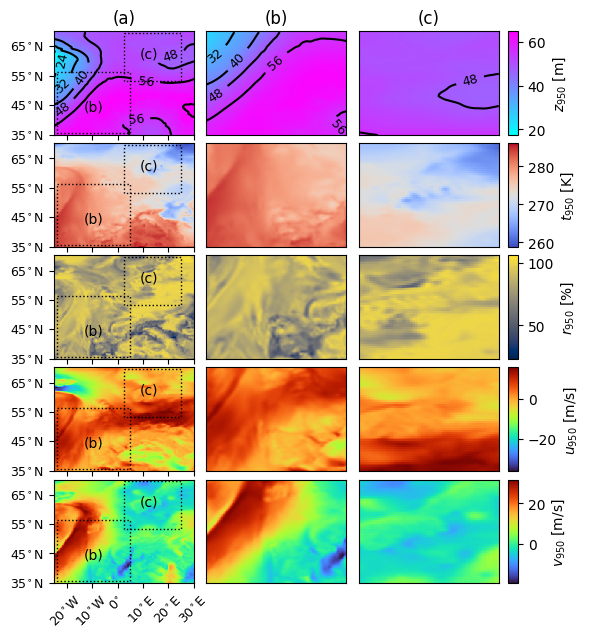

In [230]:
import matplotlib.patches as patches


def format_tick(v) -> str:
    if v.values == 0:
        return "$0^{{\circ}}$"
    elif v.values < 0:
        return f"${abs(v.values):.0f}^{{\circ}}\,\mathrm{{W}}$"
    else:
        return f"${v.values:.0f}^{{\circ}}\,\mathrm{{E}}$"


# Columns are the crops of different sizes
ncols = len(multi_crops)
# Rows are the different variables
nrows = multi_crops[0].shape[0]

fig, axs = plt.subplots(
    figsize=(2 * ncols, 1.3 * nrows),
    nrows=nrows,
    ncols=ncols,
    gridspec_kw={"width_ratios": [0.8, 0.8, 1]},
)
grid = axs.flatten()

cmaps = ["cool", "coolwarm", "cividis", "turbo", "turbo"]


for i, data in enumerate(panels):
    vmin, vmax = mins[i // ncols], maxs[i // ncols]
    field_name = field_names[i // ncols]
    ax = grid[i]
    im = ax.imshow(
        data,
        vmin=vmin,
        vmax=vmax,
        cmap=cmaps[i // ncols],
        aspect="auto",
        interpolation="nearest",
    )

    if i in list(range(2, 99, 3)):
        cbar = plt.colorbar(im, aspect=10)
        cbar.set_label(field_name)

    if i in list(range(0, 99, 3)):
        old_xticks = ax.get_xticks()
        new_xticks = np.arange(20, len(ds[coordinates.longitude]), 40)
        new_xticklabels = [
            format_tick(v) for v in ds[coordinates.longitude][new_xticks]
        ]
        ax.set_xticks(new_xticks)

        x, y = (110, 2)
        width = 90
        height = 65
        color = "black"
        rect_kwargs = dict(
            linewidth=1, linestyle=":", edgecolor=color, facecolor="none"
        )
        rect = patches.Rectangle((x, y), width, height, **rect_kwargs)
        ax.add_patch(rect)
        ax.text(x + (width / 2) - 20, y + (height / 2), "(c)", color=color)

        x, y = (5, 55)
        width = 115
        height = 83
        rect = patches.Rectangle((x, y), width, height, **rect_kwargs)
        ax.add_patch(rect)
        ax.text(x + (width / 2) - 15, y + (height / 2) + 10, "(b)", color=color)

        # only draw xticklabels for lower left plot
        if i == 12:
            pass
            ax.set_xticklabels(new_xticklabels, rotation=45, fontsize=9)
        else:
            pass
            ax.set_xticklabels([])

        old_yticks = ax.get_yticks()
        new_yticks = np.arange(20, len(ds[coordinates.latitude]), 40)
        new_yticklabels = [
            f"${v.values:.0f}^{{\circ}}\,\mathrm{{N}}$"
            for v in ds[coordinates.latitude][new_yticks]
        ]
        ax.set_yticks(new_yticks)
        ax.set_yticklabels(new_yticklabels, fontsize=9)
    else:
        ax.set_xticks([])
        ax.set_yticks([])

    if i == 0:
        ax.set_title("(a)")
    elif i == 1:
        ax.set_title("(b)")
    elif i == 2:
        ax.set_title("(c)")

    if i in [0, 1, 2]:
        contours = ax.contour(
            data, list(range(0, int(vmax) + 8, 8)), colors="k", origin="lower"
        )
        ax.clabel(contours, contours.levels, inline=True, fontsize=9)

fig.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.savefig(plots / "era5-crop-examples.pdf", bbox_inches="tight")

In [5]:
import torch.nn as nn
import sklearn.metrics
import itertools


def get_epoch_from_file_name(p: pathlib.Path) -> int:
    return int(p.name.split("-")[1])


def sort_by_epoch(paths: list[pathlib.Path]) -> list[pathlib.Path]:
    return sorted(paths, key=lambda p: get_epoch_from_file_name(p))


def calculate_ssds_with_mean_and_std(path: pathlib.Path) -> torch.Tensor:
    """Get the sum of squared (angular) distances between samples and cluster centers."""
    tensors_path = path
    distance_files = sort_by_epoch(tensors_path.glob("*-distances.pt"))
    centroids_files = sort_by_epoch(tensors_path.glob("*-centroids.pt"))
    embeddings_files = sort_by_epoch(tensors_path.glob("*-embeddings.pt"))
    assignments_files = sort_by_epoch(tensors_path.glob("*-assignments.pt"))

    device = torch.device("cpu")
    distances = [
        torch.load(file, map_location=device) for file in distance_files
    ]
    embeddings = [
        torch.load(file, map_location=device) for file in embeddings_files
    ]
    centroids = [
        torch.load(file, map_location=device) for file in centroids_files
    ]
    assignments = [
        torch.load(file, map_location=device) for file in assignments_files
    ]
    epochs = [get_epoch_from_file_name(file) for file in distance_files]

    logger.info("%s was chechpointed at epochs %s", path.as_posix(), epochs)

    def calculate_ssd(e: torch.Tensor, c: torch.Tensor) -> float:
        """Calculate the sum of squared angular distance (cosine distance = 1 - cosine similarity)."""
        head = -1
        crop = 1
        dot_products = torch.mm(e[head][crop], c.t())
        cos_sim, _ = dot_products.max(dim=1)
        return ((1 - cos_sim) ** 2).sum()

    ssd_per_head = [calculate_ssd(e, c) for e, c in zip(embeddings, centroids)]
    ssd_mean = [ssd.nanmean() for ssd in ssd_per_head]
    ssd_std = [ssd.std() for ssd in ssd_per_head]

    return epochs, ssd_per_head, ssd_mean, ssd_std


ssds_six_crops = {
    k: calculate_ssds_with_mean_and_std(p)
    for k, p in zip(ks, results, strict=True)
}

RANK 0 (LOCAL 0) - INFO - 2024-09-04 11:11:05 - 0:00:35 - /p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-2 was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599, 649, 699, 749, 799, 849, 899, 949, 999]
/tmp/ipykernel_18843/1133842414.py:40: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  ssd_std = [ssd.std() for ssd in ssd_per_head]
RANK 0 (LOCAL 0) - INFO - 2024-09-04 11:11:10 - 0:00:40 - /p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-4 was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599, 649, 699, 749, 799, 849, 899, 949, 999]
RANK 0 (LOCAL 0) - INFO - 2024-09-04 11:11:14 - 0:00:45 - /p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-

In [6]:
def plot_ssds(
    ssds_results, manual_scale_axis: bool = False, plot_individual: bool = False
):
    colors = iter(_colors.create_colors_for_labels(ks))

    ncols = 4 if plot_individual else 1
    nrows = (len(ssds_results) // 4) + 1 if plot_individual else 1

    fig, axs = plt.subplots(
        figsize=(6 * ncols, 4 * nrows),
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=True,
    )

    for i, (k, (epochs, ssd_per_head, ssd_mean, ssd_std)) in enumerate(
        ssds_results.items()
    ):
        ax = axs.flatten()[i] if plot_individual else axs

        # if k == 2:
        #     # k = 2 is extremely different and actually has a declining SSD curve
        #     continue

        # ax.plot(epochs, ssd_mean, label=rf"${k=}$", c=next(colors))
        ax.errorbar(epochs, ssd_mean, ssd_std, label=rf"${k=}$", c=next(colors))

        # For individual plots, put title instead of legend
        if plot_individual:
            ax.set_title(rf"${k=}$")

        if manual_scale_axis:
            ax.set_ylim(5e9, 2e10)
            ax.set_xlim(0, 1100)

        ax.set(yscale="log")
        ax.axvline(24, 0, 1e5)

    # For single plot, put legend
    if not plot_individual:
        fig.legend(ncol=3, bbox_to_anchor=(1, 1), loc="upper right")

    # plt.savefig(plots / "scree-test-dcv2-ssds.pdf", bbox_inches="tight")


# plot_ssds(ssds_six_crops, manual_scale_axis=False, plot_individual=False)

RANK 0 (LOCAL 0) - INFO - 2024-09-04 11:12:06 - 0:01:37 - /p/project1/deepacf/emmerich1/dcv2/mnist-1-node-1-gpu was chechpointed at epochs [0, 24, 49, 74, 99, 199, 299, 399, 499, 599, 699, 799]
/tmp/ipykernel_18843/1133842414.py:40: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  ssd_std = [ssd.std() for ssd in ssd_per_head]


[0, 24, 49, 74, 99, 199, 299, 399, 499, 599, 699, 799]


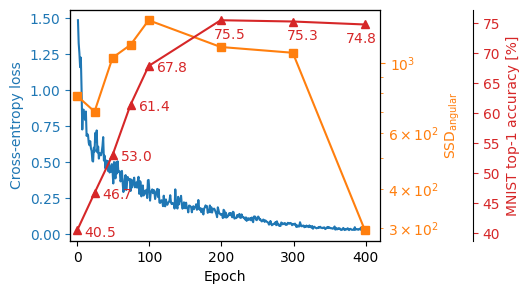

In [7]:
import pandas as pd

path_mnist = pathlib.Path(
    "/p/project1/deepacf/emmerich1/dcv2/mnist-1-node-1-gpu"
)
# Training was interrupted at epoch 439 and restarted,
# hence the metrics should only be considered from there
start = 440
end = start + 399

fig, ax = plt.subplots(figsize=(4, 3))

ax.set_xlabel("Epoch")

metrics_0 = pd.read_csv(path_mnist / "stats-rank-0.csv")

epochs = metrics_0["epoch"].iloc[start:end]
loss = metrics_0["loss"].iloc[start:end]
epochs = np.arange(1, len(loss) + 1)

ax_color = "tab:blue"

ax.plot(epochs, loss, color=ax_color)

ax.set_ylabel("Cross-entropy loss", color=ax_color)

# Plot cumulative variance on first axis
ax_color = "tab:blue"

# Create right axis.
ax_right = ax.twinx()

epochs, _, ssd_mean, _ = calculate_ssds_with_mean_and_std(path_mnist)
print(epochs)


# Plot the explained variance ratios.
ax_right_color = "tab:orange"
ax_right.set_ylabel("SSD$_{\mathrm{angular}}$", color=ax_right_color)
ax_right.plot(
    epochs[:8],
    ssd_mean[:8],
    color=ax_right_color,
    # linestyle="--",
    label="",
    marker="s",
)

acc = {
    0: 0.4049333333969116,
    24: 0.46700000762939453,
    49: 0.5301666855812073,
    74: 0.614133358001709,
    99: 0.6783833503723145,
    199: 0.7546833157539368,
    299: 0.7525500059127808,
    399: 0.7475833296775818,
}

ax_acc_color = "tab:red"

ax_acc = ax.twinx()
ax_acc.spines.right.set_position(("axes", 1.3))

x = list(acc.keys())
y = np.array(list(acc.values())) * 100

ax_acc.plot(
    x,
    y,
    color=ax_acc_color,
    marker="^",
    # linestyle="-.",
)
ax_acc.set_ylabel("MNIST top-1 accuracy [%]", color=ax_acc_color)


# loop through each x,y pair
for i, j in zip(x, y):
    if i < 199:
        xy = (i + 10, j - 1)
    elif i == 399:
        xy = (i - 28, j - 3)
    else:
        xy = (i - 10, j - 3)
    ax_acc.annotate(f"${j:.1f}$", xy=xy, color=ax_acc_color)


for ax, color, log_scale_y in [
    (ax, ax_color, False),
    (ax_right, ax_right_color, True),
    (ax_acc, ax_acc_color, False),
]:
    # Set log scale.
    if log_scale_y:
        ax.set(yscale="log")
    # Set left xlim such that the first tick disappears.
    ax.set_xlim(-10, 420)
    # Color the ticks.
    ax.tick_params(axis="y", colors=color, which="both")


plt.savefig(plots / "mnist-loss.pdf", bbox_inches="tight")

In [8]:
epoch_index = 20
print([epochs[epoch_index] for epochs, _, _, _ in ssds_six_crops.values()])

[799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799]


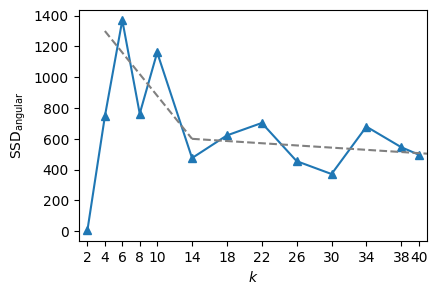

In [9]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(
    figsize=(4.5 * ncols, 3 * nrows),
    nrows=nrows,
    ncols=ncols,
    sharex=False,
    sharey=False,
)

colors = iter(_colors.create_colors_for_labels(ks))

x = list(ssds_six_crops.keys())
y = list(ssd_mean[epoch_index] for _, _, ssd_mean, _ in ssds_six_crops.values())

ax.plot(
    x,
    y,
    marker="^",
)

# Elbow
x_line = [4, 14]
y_line = [1300, 600]
ax.plot(x_line, y_line, c="gray", linestyle="--")
x_line = [14, 42]
y_line = [600, 500]
ax.plot(x_line, y_line, c="gray", linestyle="--")

ax.set(
    xlabel="$k$",
    xticks=x,
    xticklabels=x,
    ylabel="$\mathrm{SSD}_{\mathrm{angular}}$",
    # yscale="log",
    # ylim=(0, 1400),
    xlim=(1, 41),
)

plt.savefig(plots / "scree-test-dcv2.pdf", bbox_inches="tight")

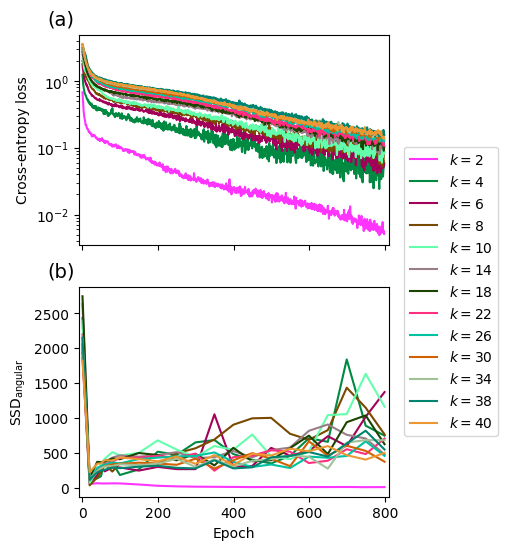

In [17]:
import pandas as pd

colors = iter(_colors.create_colors_for_labels(ks))

fig, axs = plt.subplots(figsize=(4, 6), ncols=1, nrows=2, sharex=True)

ax = axs[0]

for path in results:
    metrics_0 = pd.read_csv(path / "stats-rank-0.csv")

    epochs = metrics_0["epoch"].iloc[:799]
    loss = metrics_0["loss"].iloc[:799]

    ax.plot(
        epochs, loss, label=rf"$k={get_k_from_file_name(path)}$", c=next(colors)
    )

ax.set(
    xlim=(-10, 810),
    ylabel="Cross-entropy loss",
    # title="(a)",
    yscale="log",
)

ax.annotate(
    "(a)",
    xy=(-0.1, 1.05),
    xycoords="axes fraction",
    fontsize=14,
)

ax.legend(ncol=1, bbox_to_anchor=(1.375, 0.5), loc="upper right")


ax = axs[1]

colors = iter(_colors.create_colors_for_labels(ks))

for i, (k, (epochs, ssd_per_head, ssd_mean, ssd_std)) in enumerate(
    ssds_six_crops.items()
):
    # if k == 2:
    #     # k = 2 is extremely different and actually has a declining SSD curve
    #     continue

    ax.plot(
        epochs[: epoch_index + 1],
        ssd_mean[: epoch_index + 1],
        label=rf"${k=}$",
        c=next(colors),
    )
    # ax.errorbar(epochs, ssd_mean, ssd_std, label=rf"${k=}$", c=next(colors))

ax.set(
    xlabel="Epoch",
    ylabel="$\mathrm{SSD}_{\mathrm{angular}}$",
    # yscale="log",
    # title="(b)",
)
ax.annotate(
    "(b)",
    xy=(-0.1, 1.05),
    xycoords="axes fraction",
    fontsize=14,
)

# plt.legend(ncols=3)

plt.savefig(plots / "dcv2-loss.pdf", bbox_inches="tight")